## Data Retrieval

In [2]:
# %pip install google-cloud-bigquery
# %pip install db-dtypes
# %pip install google-cloud-bigquery-storage
# %pip install pandas-gbq
# % pip install shap

In [29]:
from pandas_gbq import read_gbq
from google.oauth2 import service_account

In [30]:
#Get df from BigQuery
creds = service_account.Credentials.from_service_account_file("car-resale-capstone-81cd3a4d7939.json")
proj_id="car-resale-capstone"

# For ML Data (Blank Cells filled with Assumptions)
ml_df = read_gbq(
    "SELECT * FROM `car-resale-capstone.car_resale_bigquery.final_ml_data`",
    project_id=proj_id,
    credentials=creds,
)
print(ml_df.head())
#print(ml_df.dtypes)

Downloading: 100%|██████████|
                                                 URL          Brand  \
0  https://carro.co/sg/en/cars/kia/cerato/kia-cer...            Kia   
1  https://carro.co/sg/en/cars/honda/civic/honda-...          Honda   
2  https://www.motorist.sg/used-car/10253/mercede...  Mercedes-Benz   
3  https://www.motorist.sg/used-car/10202/honda-s...          Honda   
4  https://www.motorist.sg/used-car/10197/honda-c...          Honda   

                            Make     Price Registration_Date   Sold  \
0                 Cerato 1.6A EX   93888.0        2020-09-24   True   
1  Civic 1.5A VTEC Turbo Sunroof   83888.0        2017-07-18   True   
2                           280S   59800.0        1978-08-31   True   
3                    S2000 2.2 M  102800.0        2008-09-24   True   
4             CIVIC TYPE-R 2.0 M   99800.0        2009-12-23  False   

   Number_of_Previous_Owners  Mileage_km  Previous_COE      OMV  ...  \
0                          1       46268    

## Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [6]:
ml_df.columns

Index(['URL', 'Brand', 'Make', 'Price', 'Registration_Date', 'Sold',
       'Number_of_Previous_Owners', 'Mileage_km', 'Previous_COE', 'OMV',
       'Road_Tax_Payable', 'COE_Expiry_Date', 'Transmission', 'Fuel_Type',
       'Engine_Capacity_cc', 'Horse_Power_kW', 'Scrape_Date', 'Posted_Date',
       'Vehicle_Age_Years', 'Vehicle_Age_Days', 'COE_Left_Days',
       'COE_Category', 'COE_Cycles', 'COE_Renewed', 'Stocks_Monthly_Avg',
       'Quota_Current_COE', 'Bids_Success_Current_COE',
       'Bids_Received_Current_COE', 'Premium_Current_COE',
       'Previous_COE_Per_Month_Remaining', 'Current_COE_Per_Month_Remaining',
       'Five_Year_COE', 'Classic_Car', 'Website'],
      dtype='object')

In [81]:
# not very useful in predictions, or correlated with other columns
drop_cols = ["URL", "Posted_Date", "Registration_Date", "COE_Expiry_Date", "Scrape_Date", "Sold", 'Current_COE_Per_Month_Remaining', 'Previous_COE_Per_Month_Remaining'] 
data = ml_df.drop(drop_cols, axis=1)

In [82]:
# data["Make3"] = (
#     data["Make"]
#     .fillna("")
#     .astype(str)
#     .str.split()
#     .str[:3]
#     .str.join(" ")
#     .str.strip()
#     .replace("", np.nan)
# )
# data = data.drop(columns=["Make"])

In [83]:
X = data.drop(columns='Price')
y = data['Price']

In [84]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

In [85]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [86]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## XGBoost

In [88]:
import xgboost 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

In [89]:
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('regressor', xgboost.XGBRegressor(objective="reg:squarederror",
    #                                    tree_method="hist",
    #                                    device='cuda',
    #                                    random_state=42,
    #                                    eval_metric="rmse"))
    #                                    ])
    ('regressor', xgboost.XGBRegressor(objective="reg:squarederror",
                                       tree_method="hist",
                                       device='cuda',
                                       random_state=42,
                                       eval_metric="rmse",
                                       subsample=np.float64(0.8),
                                       reg_lambda=np.float64(0.013895),
                                       reg_alpha=np.float64(0.1),
                                       n_estimators=np.int64(825),
                                       min_child_weight=1,
                                       max_depth=7,
                                       learning_rate=np.float64(0.03880510732210184),
                                       colsample_bytree=np.float64(0.9)))
                                       ])
xgb.fit(X_train, y_train)

c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:01:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:01:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Number_of_Previous_Owners',
                                                   'Mileage_km', 'Previous_COE',
                                                   'OMV', 'Road_Tax_Payable',
                                                   'Engine_Capacity_cc',
                                                   'Horse_Power_kW',
                                                   'Vehicle_Age_Years',
                                                   'Vehicle_Age_Days',
                                                   'COE_Left_Days',
                                                   'COE_Cycles',
                                                   'Stocks_Monthly_Avg',
                                                   'Quota_Current_COE',
                                                   'Bid...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=np.float64(0.03880510732210184),
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=np.int64(825),
                              n_jobs=None, num_parallel_tree=None, ...))])

In [90]:
# param_distributions = {
#     "model__n_estimators": np.unique(np.linspace(200, 1200, 9, dtype=int)),
#     "model__max_depth": [3, 4, 5, 6, 7, 8, 10],
#     "model__learning_rate": np.logspace(-2.3, -0.7, 10),  # ~0.005 to ~0.2
#     "model__subsample": np.linspace(0.6, 1.0, 5),
#     "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
#     "model__min_child_weight": [1, 2, 3, 5, 7, 10],
#     "model__reg_alpha": np.round(np.logspace(-4, -0.5, 8), 6),
#     "model__reg_lambda": np.round(np.logspace(-3, 1, 8), 6),
# }

In [91]:
# search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_distributions,
#     n_iter=12,                 # bump this up (e.g., 30-60) for better tuning
#     scoring="neg_root_mean_squared_error",
#     cv=3,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1,
# )

In [92]:
# search.fit(X_train, y_train)

In [93]:
# print(f"best_params: {search.best_params_}")
# print(f"train_cv_r2: {search.best_score_}")

In [94]:
# xgb_best = search.best_estimator_
# xgb_best.fit(X_train, y_train)
test_pred = xgb.predict(X_test)

In [95]:
r2 = r2_score(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mape = (abs((y_test - test_pred) / y_test).mean()) * 100

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

R²: 0.9694
MAE: 11124.1489
RMSE: 27006.6860
MAPE: 10.9926%


In [96]:
joblib.dump(xgb, "xgb_price_prediction_model")

['xgb_price_prediction_model']

### XGBoost Visualization

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

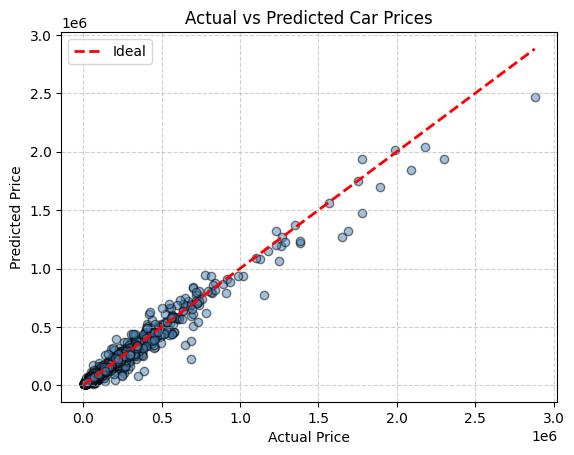

In [98]:
# actual vs predicted
plt.scatter(y_test, test_pred, alpha=0.5, color="steelblue", edgecolors="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--", linewidth=2, label="Ideal")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

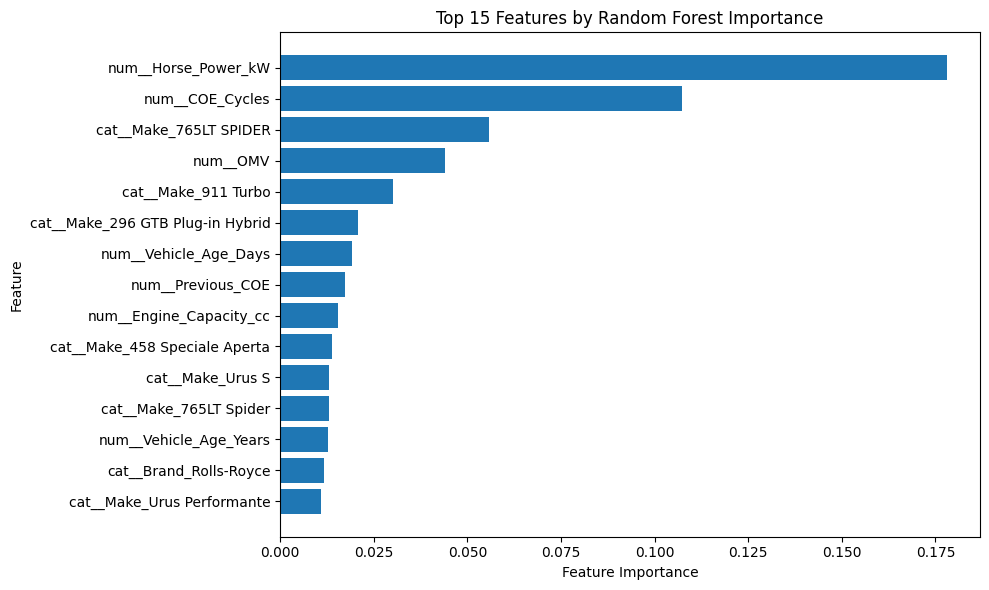

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

NUM = 15

# 1) Get feature names produced by your ColumnTransformer
feature_names = xgb.named_steps['preprocessor'].get_feature_names_out()

# 2) Get importances from the fitted forest
importances = xgb.named_steps['regressor'].feature_importances_

# 3) Put into a DataFrame and sort
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False)

# 4) Take top-N for display
top = imp_df.head(NUM).iloc[::-1]  # reverse so largest shows at top of barh

# 5) Plot (single plot, no explicit colors)
plt.figure(figsize=(10, 6))
plt.barh(top['Feature'], top['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {NUM} Features by Random Forest Importance')
plt.tight_layout()
plt.show()


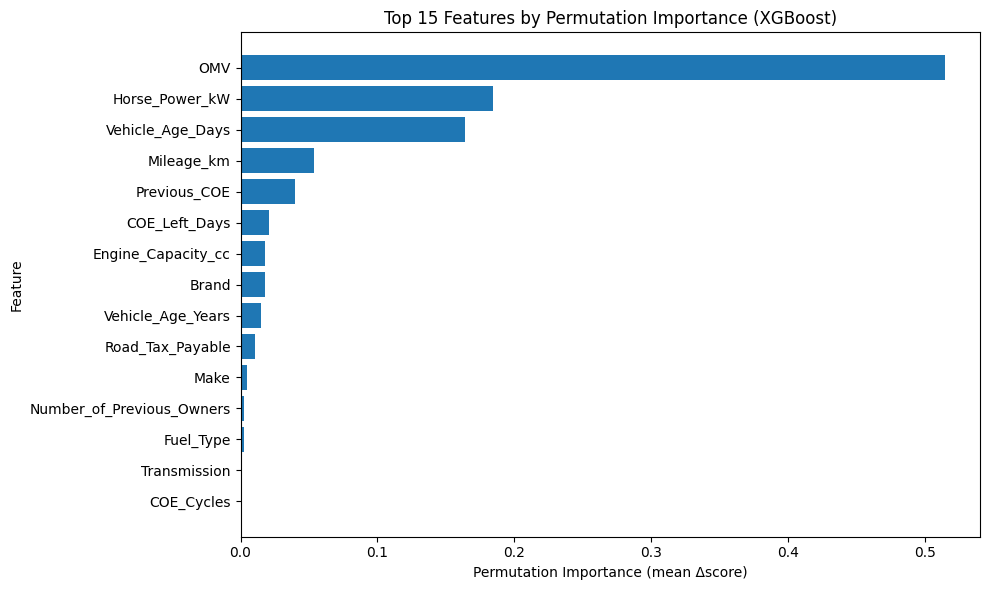

In [100]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

NUM = 15

result = permutation_importance(
    xgb, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Names must match the permuted features (pre-preprocessing)
feature_names = X_test.columns.to_list()

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

top = perm_df.head(NUM).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top['Feature'], top['Importance'])
plt.xlabel('Permutation Importance (mean Δscore)')
plt.ylabel('Feature')
plt.title(f'Top {NUM} Features by Permutation Importance (XGBoost)')
plt.tight_layout()
plt.show()


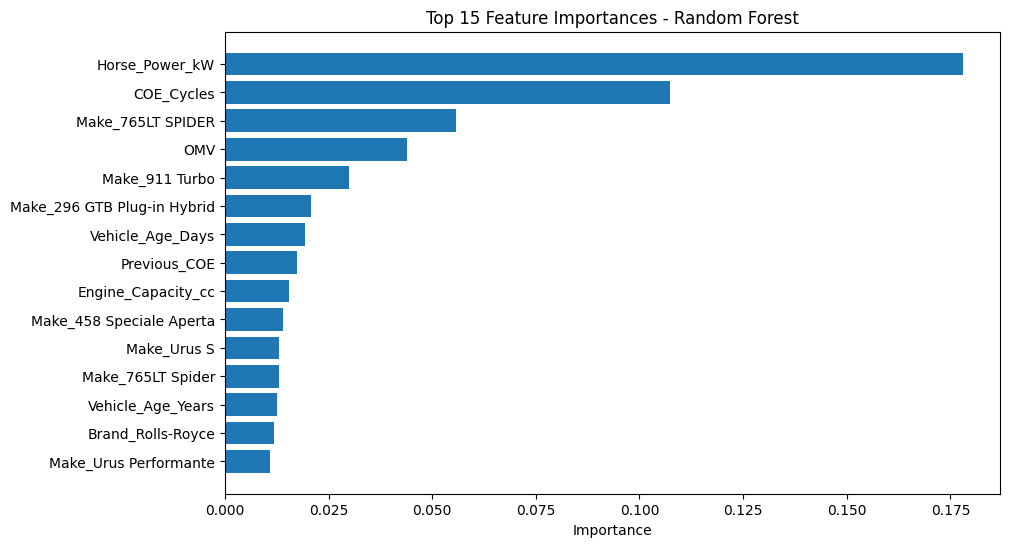

In [101]:
# top 15 important features
# Extract the trained random forest model
xgb_model = xgb.named_steps['regressor']

# Get preprocessor and feature names
preprocessor = xgb.named_steps['preprocessor']

# Get column names after one-hot encoding
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(preprocessor.transformers_[1][2])
feature_names = np.concatenate([num_features, cat_features])

# Get feature importances
importances = xgb_model.feature_importances_

# Create dataframe
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['Feature'][:15][::-1], feat_importance_df['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

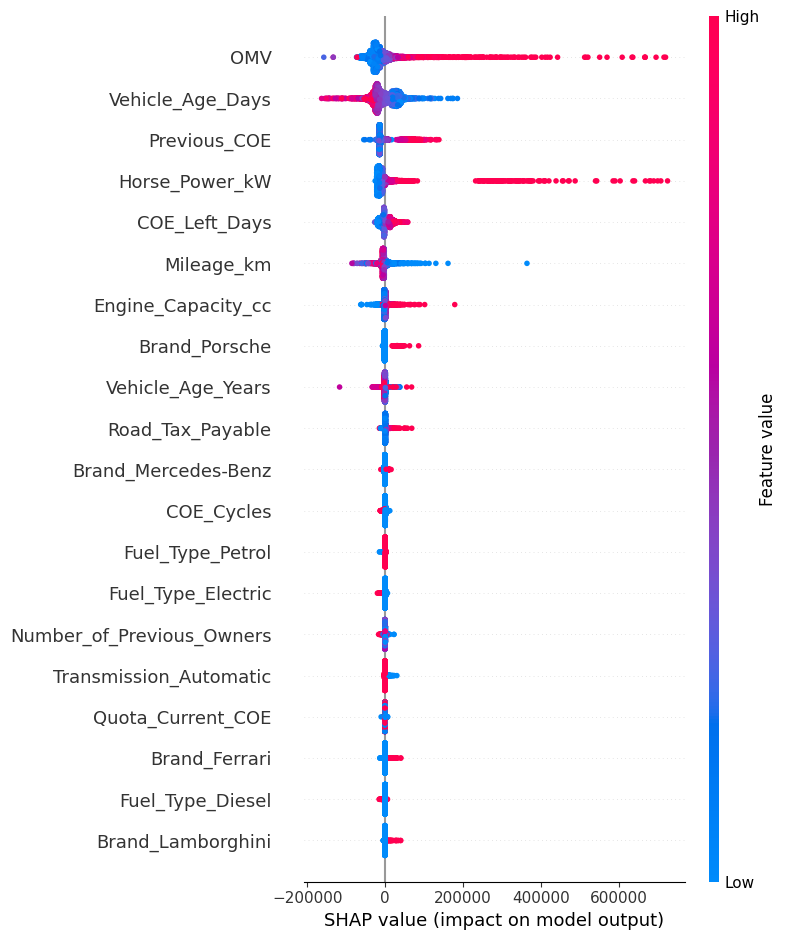

In [102]:
# Initialize explainer (use only transformed data)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

# Create SHAP summary plot
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)

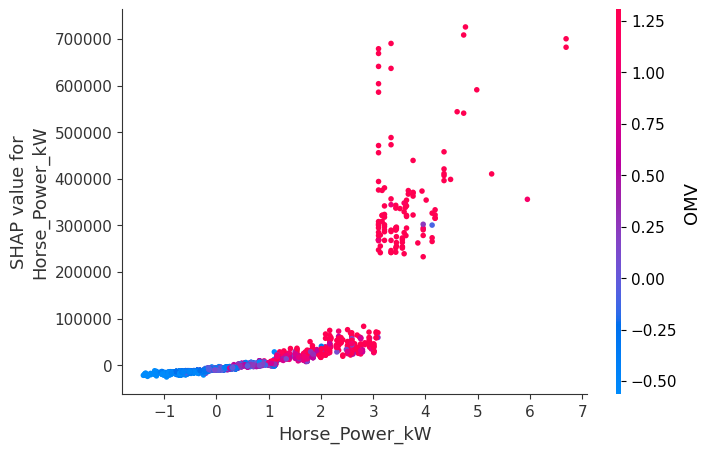

In [103]:
# Plot dependence of top feature
top_feature = feat_importance_df.iloc[0]['Feature']
shap.dependence_plot(top_feature, shap_values, X_test_transformed, feature_names=feature_names)

## XGBoost with selected features

In [104]:
# not very useful in predictions, or correlated with other columns
select_cols = ["OMV",
               "Vehicle_Age_Days", 
               "Horse_Power_kW", 
               "Previous_COE", 
               "COE_Left_Days", 
               "Mileage_km",
               "Engine_Capacity_cc",
               "Brand",
               "Road_Tax_Payable",
               "Fuel_Type",
               "Price"] 
data = ml_df[select_cols]

In [105]:
X = data.drop(columns='Price')
y = data['Price']

In [106]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

In [107]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [108]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### final model

In [110]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [111]:
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgboost.XGBRegressor(objective="reg:squarederror",
                                       tree_method="hist",
                                    #    device='cuda',
                                       random_state=42,
                                       eval_metric="rmse"))
                                       ])
    # ('regressor', xgboost.XGBRegressor(objective="reg:squarederror",
    #                                    tree_method="hist",
    #                                    device='cuda',
    #                                    random_state=42,
    #                                    eval_metric="rmse",
    #                                    subsample=np.float64(0.8),
    #                                    reg_lambda=np.float64(0.013895),
    #                                    reg_alpha=np.float64(0.1),
    #                                    n_estimators=np.int64(825),
    #                                    min_child_weight=1,
    #                                    max_depth=7,
    #                                    learning_rate=np.float64(0.03880510732210184),
    #                                    colsample_bytree=np.float64(0.9)))
    #                                    ])
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['OMV', 'Vehicle_Age_Days',
                                                   'Horse_Power_kW',
                                                   'Previous_COE',
                                                   'COE_Left_Days',
                                                   'Mileage_km',
                                                   'Engine_Capacity_cc',
                                                   'Road_Tax_Payable']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Brand'...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [112]:
param_distributions = {
    "regressor__n_estimators": np.unique(np.linspace(200, 1200, 9, dtype=int)),
    "regressor__max_depth": [3, 4, 5, 6, 7, 8, 10],
    "regressor__learning_rate": np.logspace(-2.3, -0.7, 10),  # ~0.005 to ~0.2
    "regressor__subsample": np.linspace(0.6, 1.0, 5),
    "regressor__colsample_bytree": np.linspace(0.6, 1.0, 5),
    "regressor__min_child_weight": [1, 2, 3, 5, 7, 10],
    "regressor__reg_alpha": np.round(np.logspace(-4, -0.5, 8), 6),
    "regressor__reg_lambda": np.round(np.logspace(-3, 1, 8), 6),
}

In [113]:
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=16,                 # bump this up (e.g., 30-60) for better tuning
    scoring="neg_root_mean_squared_error",
    cv=4,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

In [114]:
search.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['OMV',
                                                                                'Vehicle_Age_Days',
                                                                                'Horse_Power_kW',
                                                                                'Previous_COE',
                                                                                'COE_Left_Days',
                                                                                'Mileage_km',
                                                                                'Engine_Capacity_cc',
                                                                                'Road_Tax_Payable']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore...
                                        'regressor__reg_alpha': array([1.00000e-04, 3.16000e-04, 1.00000e-03, 3.16200e-03, 1.00000e-02,
       3.16230e-02, 1.00000e-01, 3.16228e-01]),
                                        'regressor__reg_lambda': array([1.000000e-03, 3.728000e-03, 1.389500e-02, 5.179500e-02,
       1.930700e-01, 7.196860e-01, 2.682696e+00, 1.000000e+01]),
                                        'regressor__subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [115]:
print(f"best_params: {search.best_params_}")
print(f"train_cv_r2: {search.best_score_}")

best_params: {'regressor__subsample': np.float64(0.7), 'regressor__reg_lambda': np.float64(0.013895), 'regressor__reg_alpha': np.float64(0.01), 'regressor__n_estimators': np.int64(700), 'regressor__min_child_weight': 2, 'regressor__max_depth': 7, 'regressor__learning_rate': np.float64(0.025769803745148787), 'regressor__colsample_bytree': np.float64(0.7)}
train_cv_r2: -37420.36416998552


In [116]:
xgb_best = search.best_estimator_
xgb_best.fit(X_train, y_train)
test_pred = xgb_best.predict(X_test)

In [117]:
r2 = r2_score(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
mape = (abs((y_test - test_pred) / y_test).mean()) * 100

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

R²: 0.9677
MAE: 10743.7793
RMSE: 27727.7439
MAPE: 10.6617%
